In [1]:
import pickle
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
data_dict = {}
for path in os.listdir('processed_data/'):
    data_dict[path] = []
    joined_path = f'processed_data/{path}'
    for file in os.listdir(joined_path):
        with open(os.path.join(joined_path, file), 'rb') as fin:
            data_dict[path].append(pickle.load(fin))

In [3]:
# reshape data
for key, value in data_dict.items():
    num_file = len(value)
    samples_per_file = len(value[0])
    data_dict[key] = np.array(value).reshape(num_file*samples_per_file,-1)

In [4]:
X = []
y = []
label_dict = {'no_gesture':0, 'sitting':1, 'standing':2, 'walking':3}
for key, value in data_dict.items():
    for sample in value:
        X.append(sample)
        y.append(label_dict[key])

In [5]:
#one hot encode labels
y = np.array(y)
y_encoded = np.zeros((y.size, y.max()+1))
y_encoded[np.arange(y.size),y] = 1

num_classes = 4
X = np.array(X)
y = np.array(y_encoded).reshape(-1,num_classes)

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (1298, 30000)
y shape:  (1298, 4)


In [6]:
#bad way of balancing data but fix later!!!!!!
balance_num = len(data_dict['no_gesture']) - len(data_dict['sitting'])


X_shuffled, y_shuffled = shuffle(X[balance_num:], y[balance_num:])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.1)

In [8]:
from sklearn.decomposition import KernelPCA

In [9]:
transformer = KernelPCA(n_components=128,kernel='rbf')
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_transformed)
X_test = scaler.transform(X_test_transformed)

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [12]:
nn_model = Sequential()

In [13]:
nn_model.add(Dense(64,activation='relu',input_dim=128))
nn_model.add(Dropout(.2))
nn_model.add(Dense(32, activation = 'relu'))
nn_model.add(Dense(4, activation='softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
nn_model.compile(loss="binary_crossentropy", optimizer=Adam(),
    metrics=["accuracy"])
nn_model.fit(X_train, y_train, epochs=50, batch_size=128,
    verbose=1,validation_data=(X_test,y_test))

Train on 1062 samples, validate on 118 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
1062/1062 [==============================] - 1s 608us/sample - loss: 0.5693 - acc: 0.7495 - val_loss: 0.5613 - val_acc: 0.7500
Epoch 2/50
1062/1062 [==============================] - 0s 45us/sample - loss: 0.5642 - acc: 0.7500 - val_loss: 0.5585 - val_acc: 0.7500
Epoch 3/50
1062/1062 [==============================] - 0s 49us/sample - loss: 0.5611 - acc: 0.7500 - val_loss: 0.5609 - val_acc: 0.7500
Epoch 4/50
1062/1062 [==============================] - 0s 53us/sample - loss: 0.5595 - acc: 0.7500 - val_loss: 0.5583 - val_acc: 0.7500
Epoch 5/50
1062/1062 [==============================] - 0s 49us/sample - loss: 0.5583 - acc: 0.7500 - val_loss: 0.5556 - val_acc: 0.7500
Epoch 6/50
1062/1062 [==============================] - 0s 47us/sample - loss: 0.5546 - acc: 0.7500 - val_loss: 0.5520 - val_acc: 0.7500
Epoch 7/50
1062/1062 [==============

In [15]:
pred_labels = nn_model.predict_classes(X_test)
true_labels = np.argmax(y_test,axis=1)

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels,pred_labels)

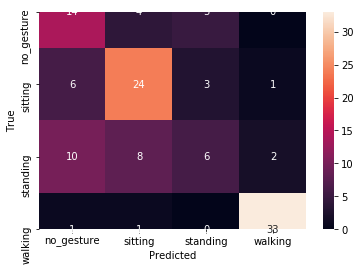

In [17]:
df_cm = pd.DataFrame(cm,label_dict.keys(),label_dict.keys())
sn.heatmap(df_cm, annot=True) # font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
cm

array([[14,  4,  5,  0],
       [ 6, 24,  3,  1],
       [10,  8,  6,  2],
       [ 1,  1,  0, 33]], dtype=int64)